In [ ]:
!pip install tensorflow

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Activation

from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization

from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score


In [ ]:
file = r'/content/drive/MyDrive/Bathymetry/ECHOSOUNDER/bathymetry_processed.csv'
df = pd.read_csv(file).dropna()

# Column
band = ['B1', 'B2', 'B3', 'B4', 'B8', 'B8A', 'B11', 'B12']
df = df[(df[band] != 0).any(axis=1)]

print(f"\n{'='*80}")
print(f"DATAFRAME")
print(f"{'='*80}")
df


DATAFRAME


,id,lat,lon,depth,wtemp,B1,B2,B3,B4,B8,B8A,B11,B12
0,0,15.514707,119.902056,0.45,31.32,0.0368,0.029180,0.046980,0.026680,0.01480,0.01090,0.0070,0.00950
1,1,15.514716,119.902062,0.85,31.32,0.0333,0.027885,0.043235,0.026635,0.01585,0.01035,0.0067,0.00875
2,2,15.514760,119.902070,0.78,31.32,0.0333,0.027885,0.043235,0.026635,0.01585,0.01035,0.0067,0.00875
3,3,15.514773,119.902070,0.45,31.31,0.0333,0.027885,0.043235,0.026635,0.01585,0.01035,0.0067,0.00875
4,4,15.514788,119.902071,0.76,31.31,0.0333,0.027885,0.043235,0.026635,0.01585,0.01035,0.0067,0.00875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49184,24020,13.916629,120.616781,1.16,31.09,0.0493,0.045670,0.057270,0.037770,0.01370,0.01360,0.0153,0.01350
49185,24021,13.916625,120.616786,1.16,31.08,0.0493,0.045670,0.057270,0.037770,0.01370,0.01360,0.0153,0.01350
49186,24022,13.916617,120.616798,1.16,31.08,0.0493,0.045670,0.057270,0.037770,0.01370,0.01360,0.0153,0.01350
49187,24023,13.916609,120.616813,1.16,31.08,0.0493,0.045670,0.057270,0.037770,0.01370,0.01360,0.0153,0.01350


In [ ]:
# Input features and target
X = df[['B1', 'B2', 'B3', 'B4', 'B8', 'B8A', 'B11', 'B12']].values
y = df['depth'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [ ]:
def create_resnet_model(input_shape=(8,), n_blocks=3, base_filters=64):
    """
    ResNet-style model

    Args:
        input_shape: Input shape (n_bands,)
        n_blocks: Number of residual blocks
        base_filters: Base number of filters

    Returns:
        Keras Model
    """
    inputs = layers.Input(shape=input_shape)

    # Initial dense layer
    x = layers.Dense(base_filters, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    # Residual blocks
    for i in range(n_blocks):
        filters = base_filters * (2 ** i)

        # Residual connection
        residual = x

        # Main path
        x = layers.Dense(filters, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Dense(filters, activation='relu')(x)
        x = layers.BatchNormalization()(x)

        # Adjust residual dimension if needed
        if residual.shape[-1] != filters:
            residual = layers.Dense(filters)(residual)

        # Add residual
        x = layers.Add()([x, residual])
        x = layers.Activation('relu')(x)

    # Output layer
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='ResNet_Bathymetry')

    return model


def create_simple_mlp(input_shape=(8,)):
    """MLP baseline for comparison"""
    inputs = layers.Input(shape=input_shape)

    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MLP_Bathymetry')

    return model


def create_attention_model(input_shape=(8,)):
    """
    Model with band attention mechanism
    Learns which bands are most important for depth prediction
    """
    inputs = layers.Input(shape=input_shape)

    # Band attention
    attention_weights = layers.Dense(input_shape[0], activation='softmax', name='band_attention')(inputs)
    x = layers.Multiply()([inputs, attention_weights])

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Attention_Bathymetry')

    return model

In [ ]:
class PINNWrapper(Model):
    """
    Physics-Informed Neural Network for bathymetry estimation

    """

    def __init__(self, base_model, n_bands=8, lambda_phy=0.1,
                 depth_min=0.0, depth_max=30.0, adaptive_lambda=True):
        super().__init__()

        self.base_model = base_model
        self.n_bands = n_bands
        self.depth_min = depth_min
        self.depth_max = depth_max
        self.adaptive_lambda = adaptive_lambda
        self.lambda_phy_initial = lambda_phy

        # Learnable parameters per band
        # Initialize based on typical coastal water values
        self.k = tf.Variable(
            initial_value=tf.constant([0.05, 0.08, 0.12, 0.15, 0.10, 0.13, 0.20, 0.25],
                                     dtype=tf.float32)[:n_bands],
            trainable=True,
            name='attenuation_k'
        )

        self.R0 = tf.Variable(
            initial_value=tf.ones(n_bands, dtype=tf.float32) * 0.15,
            trainable=True,
            name='shallow_reflectance'
        )

        self.Rinf = tf.Variable(
            initial_value=tf.ones(n_bands, dtype=tf.float32) * 0.05,
            trainable=True,
            name='deep_reflectance'
        )

        # Adaptive lambda (starts high, decays over time)
        self.lambda_phy = tf.Variable(
            initial_value=lambda_phy,
            trainable=False,
            dtype=tf.float32,
            name='lambda_phy'
        )

        # Loss and metrics
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        self.rmse_metric = tf.keras.metrics.RootMeanSquaredError(name='rmse')
        self.mae_metric = tf.keras.metrics.MeanAbsoluteError(name='mae')

        # Track loss components
        self.data_loss_tracker = tf.keras.metrics.Mean(name='loss_data')
        self.phy_loss_tracker = tf.keras.metrics.Mean(name='loss_phy')
        self.total_loss_tracker = tf.keras.metrics.Mean(name='loss')

    def compile(self, optimizer, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.rmse_metric,
            self.mae_metric,
            self.data_loss_tracker,
            self.phy_loss_tracker
        ]

    def apply_depth_constraint(self, depth_pred):
        """Ensure predicted depths are within physical bounds"""
        return tf.clip_by_value(depth_pred, self.depth_min, self.depth_max)

    def beer_lambert_law(self, depth, band_idx=None):
        """
        Compute expected reflectance using Beer-Lambert law

        R(z) = R_inf + (R_0 - R_inf) * exp(-k * z)

        """
        if band_idx is not None:
            # Single band
            k = self.k[band_idx]
            R0 = self.R0[band_idx]
            Rinf = self.Rinf[band_idx]
            return Rinf + (R0 - Rinf) * tf.exp(-k * depth)
        else:
            # All bands
            k = tf.reshape(self.k, [1, -1])  # (1, n_bands)
            R0 = tf.reshape(self.R0, [1, -1])
            Rinf = tf.reshape(self.Rinf, [1, -1])
            depth_expanded = tf.expand_dims(depth, -1)  # (batch, 1, 1)
            return Rinf + (R0 - Rinf) * tf.exp(-k * depth_expanded)

    def compute_physics_loss(self, reflectance_obs, depth_pred):
        """
        Compute physics-informed loss across all bands

        Args:
            reflectance_obs: Observed reflectance (batch_size, n_bands)
            depth_pred: Predicted depth (batch_size, 1)

        Returns:
            Physics loss (scalar)
        """
        # Compute expected reflectance from Beer-Lambert law
        reflectance_sim = self.beer_lambert_law(depth_pred)

        # MSE between observed and simulated reflectance
        loss_phy = self.loss_fn(reflectance_obs, reflectance_sim)

        # Add regularization to keep k, R0, Rinf physically reasonable
        k_reg = tf.reduce_mean(tf.maximum(0.0, -self.k))  # k should be positive
        R_reg = tf.reduce_mean(tf.maximum(0.0, self.Rinf - self.R0))  # R0 > Rinf

        return loss_phy + 0.01 * (k_reg + R_reg)

    def update_lambda(self, epoch, total_epochs):
        """
        Adaptive lambda scheduling: start high, decay over time
        Helps physics guide early training, data dominate later
        """
        if self.adaptive_lambda:
            # Cosine annealing
            progress = epoch / total_epochs
            lambda_new = self.lambda_phy_initial * (0.1 + 0.9 * np.cos(progress * np.pi))
            self.lambda_phy.assign(lambda_new)

    def train_step(self, data):
        (x, reflectance_obs), y_true = data

        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = self.base_model(x, training=True)

            # Apply depth constraint
            y_pred = self.apply_depth_constraint(y_pred)

            # Data loss (MSE between true and predicted depth)
            loss_data = self.loss_fn(y_true, y_pred)

            # Physics loss (Beer-Lambert consistency)
            loss_phy = self.compute_physics_loss(reflectance_obs, y_pred)

            # Total loss with adaptive weighting
            total_loss = loss_data + self.lambda_phy * loss_phy

        # Compute gradients and apply (with clipping for stability)
        grads = tape.gradient(total_loss, self.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, 1.0)  # Gradient clipping
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.data_loss_tracker.update_state(loss_data)
        self.phy_loss_tracker.update_state(loss_phy)
        self.rmse_metric.update_state(y_true, y_pred)
        self.mae_metric.update_state(y_true, y_pred)

        return {
            "loss": self.total_loss_tracker.result(),
            "rmse": self.rmse_metric.result(),
            "mae": self.mae_metric.result(),
            "loss_data": self.data_loss_tracker.result(),
            "loss_phy": self.phy_loss_tracker.result(),
            "lambda": self.lambda_phy,
            "k_mean": tf.reduce_mean(self.k)
        }

    def test_step(self, data):
        (x, reflectance_obs), y_true = data

        # Forward pass
        y_pred = self.base_model(x, training=False)
        y_pred = self.apply_depth_constraint(y_pred)

        # Losses
        loss_data = self.loss_fn(y_true, y_pred)
        loss_phy = self.compute_physics_loss(reflectance_obs, y_pred)
        total_loss = loss_data + self.lambda_phy * loss_phy

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.data_loss_tracker.update_state(loss_data)
        self.phy_loss_tracker.update_state(loss_phy)
        self.rmse_metric.update_state(y_true, y_pred)
        self.mae_metric.update_state(y_true, y_pred)

        return {
            "loss": self.total_loss_tracker.result(),
            "rmse": self.rmse_metric.result(),
            "mae": self.mae_metric.result(),
            "loss_data": self.data_loss_tracker.result(),
            "loss_phy": self.phy_loss_tracker.result()
        }

    def call(self, inputs):
        """Forward pass through base model"""
        if isinstance(inputs, tuple):
            x, _ = inputs
        else:
            x = inputs
        return self.base_model(x, training=False)


In [ ]:
def prepare_improved_pinn_training(X_train, y_train, X_test, y_test,
                                  base_model, n_bands=8):
    """
    Prepare data and model for improved PINN training
    """

    print("="*70)
    print("SETTING UP IMPROVED PINN TRAINING")
    print("="*70)

    # Estimate initial R0 and Rinf from data
    shallow_mask = y_train < np.percentile(y_train, 10)  # Shallow 10%
    deep_mask = y_train > np.percentile(y_train, 90)     # Deep 10%

    R0_estimate = np.median(X_train[shallow_mask], axis=0)
    Rinf_estimate = np.median(X_train[deep_mask], axis=0)

    print(f"\nInitial estimates:")
    print(f"  R0 (shallow):  {R0_estimate}")
    print(f"  Rinf (deep):   {Rinf_estimate}")
    print(f"  Depth range:   {y_train.min():.2f} - {y_train.max():.2f} m")

    # Create datasets with full reflectance (not just one band)
    batch_size = 64  # Increased from 32

    train_dataset = tf.data.Dataset.from_tensor_slices(
        ((X_train, X_train), y_train)  # Use full reflectance
    ).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices(
        ((X_test, X_test), y_test)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Create PINN model
    pinn_model = PINNWrapper(
        base_model=base_model,
        n_bands=n_bands,
        lambda_phy=1.0,  # High physics weight
        depth_min=0.0,
        depth_max=y_train.max() * 1.2,  # 20% buffer
        adaptive_lambda=True
    )

    # Compile with modern optimizer
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-3,
        weight_decay=1e-5
    )

    pinn_model.compile(optimizer=optimizer)

    # Enhanced callbacks
    callbacks = [
        # Learning rate scheduling
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=20,
            min_lr=1e-6,
            verbose=1,
            mode='min'
        ),

        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_rmse',
            patience=50,
            restore_best_weights=True,
            verbose=1,
            mode='min'
        ),

        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'best_pinn_model.keras',
            monitor='val_rmse',
            save_best_only=True,
            verbose=1,
            mode='min'
        ),

        # Lambda adaptation callback
        LambdaSchedulerCallback(pinn_model, total_epochs=500)
    ]

    print(f"\nTraining configuration:")
    print(f"  Batch size: {batch_size}")
    print(f"  Initial LR: 1e-3")
    print(f"  Optimizer: AdamW")
    print(f"  Physics weight: Adaptive (1.0 → 0.1)")
    print("="*70)

    return pinn_model, train_dataset, test_dataset, callbacks

In [ ]:
class LambdaSchedulerCallback(tf.keras.callbacks.Callback):
    """Update physics loss weight during training"""

    def __init__(self, pinn_model, total_epochs):
        super().__init__()
        self.pinn_model = pinn_model
        self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):
        self.pinn_model.update_lambda(epoch, self.total_epochs)

In [ ]:
class PhysicsMonitorCallback(tf.keras.callbacks.Callback):
    """Monitor learned physics parameters"""

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 50 == 0:
            k = self.model.k.numpy()
            R0 = self.model.R0.numpy()
            Rinf = self.model.Rinf.numpy()

            print(f"\n[Physics Parameters @ Epoch {epoch}]")
            print(f"  k (attenuation):    {k}")
            print(f"  R0 (shallow):       {R0}")
            print(f"  Rinf (deep):        {Rinf}")

In [ ]:
def plot_training_history(history):
    """Plot comprehensive training history"""

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Total loss
    axes[0, 0].plot(history.history['loss'], label='Train')
    axes[0, 0].plot(history.history['val_loss'], label='Val')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # RMSE
    axes[0, 1].plot(history.history['rmse'], label='Train')
    axes[0, 1].plot(history.history['val_rmse'], label='Val')
    axes[0, 1].set_title('RMSE')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('RMSE (m)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # MAE
    axes[0, 2].plot(history.history['mae'], label='Train')
    axes[0, 2].plot(history.history['val_mae'], label='Val')
    axes[0, 2].set_title('MAE')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('MAE (m)')
    axes[0, 2].legend()
    axes[0, 2].grid(True)

    # Data loss
    axes[1, 0].plot(history.history['loss_data'], label='Train')
    axes[1, 0].plot(history.history['val_loss_data'], label='Val')
    axes[1, 0].set_title('Data Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Physics loss
    axes[1, 1].plot(history.history['loss_phy'], label='Train')
    axes[1, 1].plot(history.history['val_loss_phy'], label='Val')
    axes[1, 1].set_title('Physics Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    # Lambda schedule
    axes[1, 2].plot(history.history['lambda'])
    axes[1, 2].set_title('Physics Weight (λ)')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('λ')
    axes[1, 2].grid(True)

    plt.tight_layout()
    plt.savefig('pinn_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Saved training history plot: pinn_training_history.png")

In [ ]:
def evaluate_pinn(pinn_model, X_test, y_test):
    """Comprehensive evaluation of PINN model"""

    print("\n" + "="*70)
    print("PINN MODEL EVALUATION")
    print("="*70)

    # Predictions
    y_pred = pinn_model.predict((X_test, X_test))

    # Metrics
    rmse = np.sqrt(np.mean((y_test - y_pred.flatten())**2))
    mae = np.mean(np.abs(y_test - y_pred.flatten()))
    r2 = 1 - np.sum((y_test - y_pred.flatten())**2) / np.sum((y_test - y_test.mean())**2)

    print(f"\nPerformance Metrics:")
    print(f"  RMSE:  {rmse:.3f} m")
    print(f"  MAE:   {mae:.3f} m")
    print(f"  R²:    {r2:.3f}")

    # Learned physics parameters
    print(f"\nLearned Physics Parameters:")
    print(f"  k (attenuation):  {pinn_model.k.numpy()}")
    print(f"  R0 (shallow):     {pinn_model.R0.numpy()}")
    print(f"  Rinf (deep):      {pinn_model.Rinf.numpy()}")

    # Scatter plot
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.5, s=10)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2)
    plt.xlabel('True Depth (m)', fontsize=12)
    plt.ylabel('Predicted Depth (m)', fontsize=12)
    plt.title(f'PINN Predictions (RMSE: {rmse:.3f}m, R²: {r2:.3f})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Bathymetry/MODEL/PINN/pinn_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Saved predictions plot: pinn_predictions.png")
    print("="*70)

    return rmse, mae, r2

COMPLETE PINN BATHYMETRY WORKFLOW

1. Creating base model...
   ✓ Base model created: ResNet_Bathymetry
   ✓ Input shape: 8 bands
   ✓ Parameters: 194,241

2. Setting up PINN wrapper...
SETTING UP IMPROVED PINN TRAINING

Initial estimates:
  R0 (shallow):  [0.0714  0.04402 0.06316 0.04177 0.0495  0.04135 0.0301  0.025  ]
  Rinf (deep):   [0.0508  0.02999 0.02688 0.00702 0.0267  0.0278  0.028   0.0243 ]
  Depth range:   0.26 - 40.30 m

Training configuration:
  Batch size: 64
  Initial LR: 1e-3
  Optimizer: AdamW
  Physics weight: Adaptive (1.0 → 0.1)

3. Starting PINN training...
Epoch 1/500
576/577 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - k_mean: 0.1350 - lambda: 1.0000 - loss: 3.6226 - loss_data: 3.6142 - loss_phy: 0.0085 - mae: 1.2387 - rmse: 1.8805
Epoch 1: val_rmse improved from inf to 2.16470, saving model to best_pinn_model.keras


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



[Physics Parameters @ Epoch 0]
  k (attenuation):    [0.05 0.08 0.12 0.15 0.1  0.13 0.2  0.25]
  R0 (shallow):       [0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15]
  Rinf (deep):        [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]
577/577 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - k_mean: 0.1350 - lambda: 1.0000 - loss: 3.6191 - loss_data: 3.6107 - loss_phy: 0.0085 - mae: 1.2380 - rmse: 1.8796 - val_loss: 4.6792 - val_loss_data: 4.6699 - val_loss_phy: 0.0093 - val_mae: 1.2089 - val_rmse: 2.1647 - learning_rate: 0.0010
Epoch 2/500
575/577 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - k_mean: 0.1350 - lambda: 1.0000 - loss: 1.7699 - loss_data: 1.7618 - loss_phy: 0.0081 - mae: 0.8450 - rmse: 1.3272
Epoch 2: val_rmse improved from 2.16470 to 1.26318, saving model to best_pinn_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - k_mean: 0.1350 - lambda: 1.0000 - loss: 1.7698 - loss_data: 1.7617 - loss_phy: 0.0081 - mae: 0.8449 - rmse: 1.3271 - val_loss: 1.6013 - val_loss_data: 1.5934 - val_loss_phy: 0.0079 - v

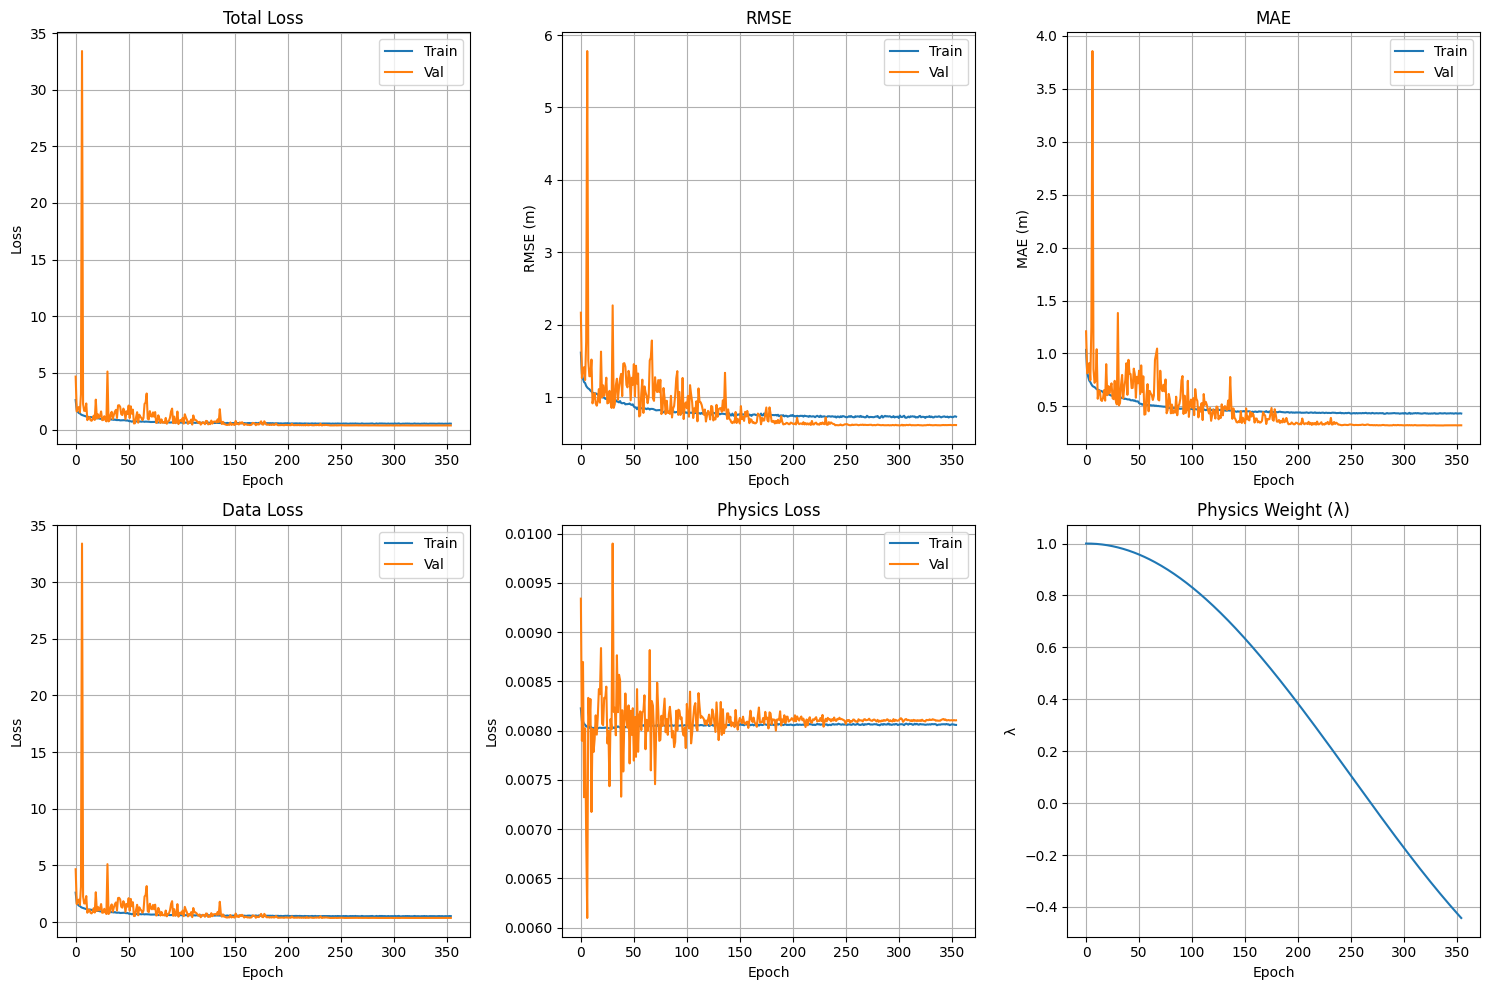


✅ Saved training history plot: pinn_training_history.png

5. Final evaluation...

PINN MODEL EVALUATION
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Performance Metrics:
  RMSE:  0.607 m
  MAE:   0.321 m
  R²:    0.920

Learned Physics Parameters:
  k (attenuation):  [0.05 0.08 0.12 0.15 0.1  0.13 0.2  0.25]
  R0 (shallow):     [0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15]
  Rinf (deep):      [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]


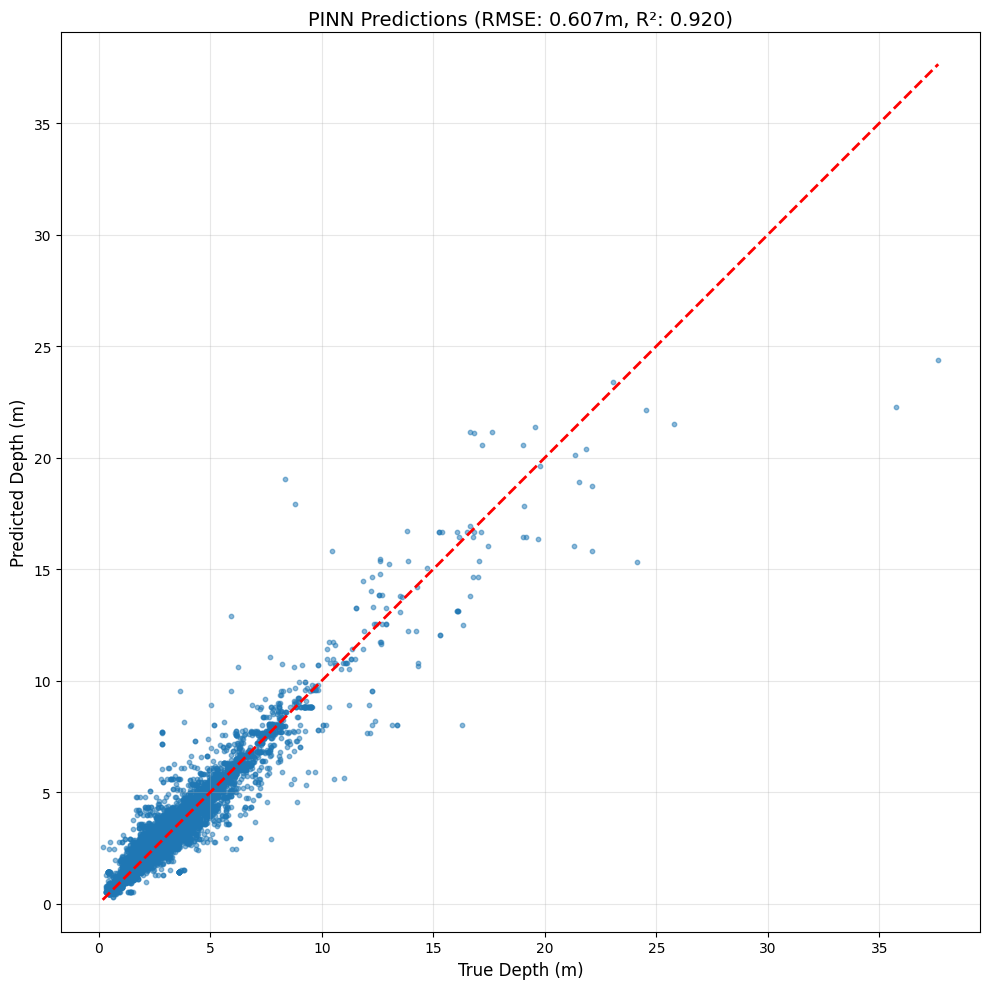


✅ Saved predictions plot: pinn_predictions.png

6. Saving trained model...
   ✓ Base model saved: /content/drive/MyDrive/Bathymetry/MODEL/PINN/base_model.keras
   ✓ Physics params saved: saved_pinn_model/physics_params.npy
   ✓ Training history saved: saved_pinn_model/training_history.csv

✅ TRAINING COMPLETE!
Final Test RMSE: 0.607 m
Final Test MAE:  0.321 m
Final Test R²:   0.920

Model saved to: saved_pinn_model/
  - base_model.keras (for inference)
  - physics_params.npy (learned physics)
  - training_history.csv (loss curves)

7. Testing inference on a sample...

Sample Predictions:
  Sample 1: True=0.78m, Predicted=0.97m
  Sample 2: True=1.71m, Predicted=1.81m
  Sample 3: True=0.74m, Predicted=0.71m
  Sample 4: True=2.09m, Predicted=1.85m
  Sample 5: True=0.81m, Predicted=0.73m

🎉 All done! Use the saved model for inference:
   model = tf.keras.models.load_model('saved_pinn_model/base_model.keras')
   depths = model.predict(new_reflectance_data)


In [ ]:
if __name__ == "__main__":

    print("="*70)
    print("COMPLETE PINN BATHYMETRY WORKFLOW")
    print("="*70)

    # Step 1: Create base model
    print("\n1. Creating base model...")
    resnet_model = create_resnet_model(
        input_shape=(X_train.shape[1],),
        n_blocks=3,
        base_filters=64
    )

    print(f"   ✓ Base model created: {resnet_model.name}")
    print(f"   ✓ Input shape: {X_train.shape[1]} bands")
    print(f"   ✓ Parameters: {resnet_model.count_params():,}")

    # Step 2: Setup improved PINN
    print("\n2. Setting up PINN wrapper...")
    pinn_model, train_ds, test_ds, callbacks = prepare_improved_pinn_training(
        X_train, y_train, X_test, y_test,
        base_model=resnet_model,
        n_bands=X_train.shape[1]
    )

    # Add physics monitoring
    callbacks.append(PhysicsMonitorCallback())

    # Step 3: Train
    print("\n3. Starting PINN training...")
    history = pinn_model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=500,
        callbacks=callbacks,
        verbose=1
    )

    # Step 4: Visualize training
    print("\n4. Generating training plots...")
    plot_training_history(history)

    # Step 5: Evaluate
    print("\n5. Final evaluation...")
    rmse, mae, r2 = evaluate_pinn(pinn_model, X_test, y_test)

    # Step 6: SAVE MODEL PROPERLY (IMPORTANT!)
    print("\n6. Saving trained model...")
    import os
    os.makedirs('saved_pinn_model', exist_ok=True)

    # Save base model (for inference)
    pinn_model.base_model.save('/content/drive/MyDrive/Bathymetry/MODEL/PINN/base_model.keras')
    print("   ✓ Base model saved: /content/drive/MyDrive/Bathymetry/MODEL/PINN/base_model.keras")

    # Save physics parameters (for reference)

    physics_params = {
        'k': pinn_model.k.numpy(),
        'R0': pinn_model.R0.numpy(),
        'Rinf': pinn_model.Rinf.numpy(),
        'n_bands': int(pinn_model.n_bands),
        'depth_min': float(pinn_model.depth_min),
        'depth_max': float(pinn_model.depth_max),
        'final_rmse': float(rmse),
        'final_mae': float(mae),
        'final_r2': float(r2)
    }
    np.save('/content/drive/MyDrive/Bathymetry/MODEL/PINN/physics_params.npy', physics_params)
    print("   ✓ Physics params saved: saved_pinn_model/physics_params.npy")

    # Save training history
    import pandas as pd
    history_df = pd.DataFrame(history.history)
    history_df.to_csv('/content/drive/MyDrive/Bathymetry/MODEL/PINN/training_history.csv', index=False)
    print("   ✓ Training history saved: saved_pinn_model/training_history.csv")

    # Final summary
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"Final Test RMSE: {rmse:.3f} m")
    print(f"Final Test MAE:  {mae:.3f} m")
    print(f"Final Test R²:   {r2:.3f}")
    print(f"\nModel saved to: saved_pinn_model/")
    print(f"  - base_model.keras (for inference)")
    print(f"  - physics_params.npy (learned physics)")
    print(f"  - training_history.csv (loss curves)")
    print("="*70)

    # Step 7: Quick test inference
    print("\n7. Testing inference on a sample...")
    test_sample = X_test[:5]  # First 5 test samples
    predictions = pinn_model.base_model.predict(test_sample, verbose=0)

    print("\nSample Predictions:")
    for i in range(len(test_sample)):
        print(f"  Sample {i+1}: True={y_test[i]:.2f}m, Predicted={predictions[i][0]:.2f}m")

    print("\n🎉 All done! Use the saved model for inference:")
    print("   model = tf.keras.models.load_model('saved_pinn_model/base_model.keras')")
    print("   depths = model.predict(new_reflectance_data)")

In [1]:
# @title
from IPython.display import HTML

html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>PINN Training Explained</title>
    <style>
        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }

        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            padding: 20px;
            line-height: 1.6;
        }

        .container {
            max-width: 1200px;
            margin: 0 auto;
            background: white;
            border-radius: 20px;
            box-shadow: 0 20px 60px rgba(0,0,0,0.3);
            overflow: hidden;
        }

        .header {
            background: linear-gradient(135deg, #1e3c72 0%, #2a5298 100%);
            color: white;
            padding: 40px;
            text-align: center;
        }

        .header h1 {
            font-size: 2.5em;
            margin-bottom: 10px;
        }

        .header p {
            font-size: 1.2em;
            opacity: 0.9;
        }

        .content {
            padding: 40px;
        }

        .section {
            margin-bottom: 40px;
            padding: 30px;
            background: #f8f9fa;
            border-radius: 15px;
            border-left: 5px solid #667eea;
        }

        .section h2 {
            color: #1e3c72;
            margin-bottom: 20px;
            font-size: 1.8em;
            display: flex;
            align-items: center;
            gap: 10px;
        }

        .section h3 {
            color: #2a5298;
            margin: 20px 0 10px 0;
            font-size: 1.3em;
        }

        .icon {
            font-size: 1.5em;
        }

        .code-block {
            background: #2d2d2d;
            color: #f8f8f2;
            padding: 20px;
            border-radius: 10px;
            overflow-x: auto;
            margin: 15px 0;
            font-family: 'Courier New', monospace;
            font-size: 0.9em;
        }

        .highlight {
            background: #fff3cd;
            padding: 2px 6px;
            border-radius: 3px;
            font-weight: bold;
        }

        .flow-diagram {
            display: flex;
            flex-wrap: wrap;
            gap: 15px;
            margin: 20px 0;
            justify-content: center;
        }

        .flow-step {
            background: white;
            border: 3px solid #667eea;
            border-radius: 10px;
            padding: 20px;
            flex: 1;
            min-width: 200px;
            text-align: center;
            position: relative;
            transition: transform 0.3s ease;
        }

        .flow-step:hover {
            transform: translateY(-5px);
            box-shadow: 0 10px 25px rgba(0,0,0,0.15);
        }

        .flow-step::after {
            content: '→';
            position: absolute;
            right: -25px;
            top: 50%;
            transform: translateY(-50%);
            font-size: 2em;
            color: #667eea;
        }

        .flow-step:last-child::after {
            content: '';
        }

        .flow-step h4 {
            color: #667eea;
            margin-bottom: 10px;
            font-size: 1.1em;
        }

        .equation {
            background: white;
            padding: 20px;
            border-radius: 10px;
            margin: 15px 0;
            text-align: center;
            font-size: 1.2em;
            border: 2px solid #e0e0e0;
        }

        .equation-label {
            color: #666;
            font-size: 0.9em;
            margin-top: 10px;
        }

        .comparison-table {
            width: 100%;
            border-collapse: collapse;
            margin: 20px 0;
            background: white;
            border-radius: 10px;
            overflow: hidden;
        }

        .comparison-table th {
            background: #667eea;
            color: white;
            padding: 15px;
            text-align: left;
        }

        .comparison-table td {
            padding: 15px;
            border-bottom: 1px solid #e0e0e0;
        }

        .comparison-table tr:hover {
            background: #f8f9fa;
        }

        .metric-box {
            display: inline-block;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 15px 25px;
            border-radius: 10px;
            margin: 10px;
            text-align: center;
            min-width: 150px;
        }

        .metric-box .value {
            font-size: 2em;
            font-weight: bold;
        }

        .metric-box .label {
            font-size: 0.9em;
            opacity: 0.9;
        }

        .timeline {
            position: relative;
            padding-left: 40px;
            margin: 20px 0;
        }

        .timeline::before {
            content: '';
            position: absolute;
            left: 15px;
            top: 0;
            bottom: 0;
            width: 3px;
            background: #667eea;
        }

        .timeline-item {
            position: relative;
            margin-bottom: 30px;
            padding: 20px;
            background: white;
            border-radius: 10px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
        }

        .timeline-item::before {
            content: '';
            position: absolute;
            left: -32px;
            top: 25px;
            width: 15px;
            height: 15px;
            border-radius: 50%;
            background: #667eea;
            border: 3px solid white;
        }

        .timeline-item h4 {
            color: #667eea;
            margin-bottom: 10px;
        }

        .alert {
            padding: 15px 20px;
            border-radius: 10px;
            margin: 15px 0;
            display: flex;
            align-items: center;
            gap: 15px;
        }

        .alert-info {
            background: #d1ecf1;
            border-left: 5px solid #0c5460;
            color: #0c5460;
        }

        .alert-success {
            background: #d4edda;
            border-left: 5px solid #155724;
            color: #155724;
        }

        .alert-warning {
            background: #fff3cd;
            border-left: 5px solid #856404;
            color: #856404;
        }

        .tabs {
            display: flex;
            gap: 10px;
            margin-bottom: 20px;
            border-bottom: 2px solid #e0e0e0;
        }

        .tab {
            padding: 10px 20px;
            cursor: pointer;
            border: none;
            background: none;
            font-size: 1em;
            color: #666;
            transition: all 0.3s ease;
        }

        .tab:hover {
            color: #667eea;
        }

        .tab.active {
            color: #667eea;
            border-bottom: 3px solid #667eea;
            font-weight: bold;
        }

        .tab-content {
            display: none;
            animation: fadeIn 0.5s;
        }

        .tab-content.active {
            display: block;
        }

        @keyframes fadeIn {
            from { opacity: 0; transform: translateY(10px); }
            to { opacity: 1; transform: translateY(0); }
        }
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <h1>🌊 Physics-Informed Neural Network (PINN)</h1>
            <p>Complete Training Explanation for Bathymetry Estimation</p>
        </div>

        <div class="content">
            <!-- Section 1: Overview -->
            <div class="section">
                <h2><span class="icon">🎯</span> What is This Model?</h2>
                <p>A <strong>Physics-Informed Neural Network (PINN)</strong> combines:</p>
                <div class="flow-diagram">
                    <div class="flow-step">
                        <h4>🤖 Neural Network</h4>
                        <p>Learns patterns from data</p>
                        <small>Sentinel-2 reflectance → depth</small>
                    </div>
                    <div class="flow-step">
                        <h4>⚛️ Physics Laws</h4>
                        <p>Beer-Lambert Law</p>
                        <small>Light attenuation in water</small>
                    </div>
                    <div class="flow-step">
                        <h4>📊 Best of Both</h4>
                        <p>Accurate + Realistic</p>
                        <small>Better predictions</small>
                    </div>
                </div>

                <div class="alert alert-info">
                    <span style="font-size: 2em;">💡</span>
                    <div>
                        <strong>Key Insight:</strong> Traditional models only learn from data. PINN also learns from physics, making predictions more accurate and physically realistic.
                    </div>
                </div>
            </div>

            <!-- Section 2: The Architecture -->
            <div class="section">
                <h2><span class="icon">🏗️</span> Model Architecture</h2>

                <div class="tabs">
                    <button class="tab active" onclick="showTab('arch1')">ResNet Base</button>
                    <button class="tab" onclick="showTab('arch2')">PINN Wrapper</button>
                    <button class="tab" onclick="showTab('arch3')">Complete Flow</button>
                </div>

                <div id="arch1" class="tab-content active">
                    <h3>1. Base Model: ResNet</h3>
                    <div class="code-block">
Input: 8 Sentinel-2 bands [B1, B2, B3, B4, B8, B8A, B11, B12]
    ↓
Dense(64) + BatchNorm + ReLU
    ↓
[Residual Block 1] 64 filters
    Dense → BatchNorm → Dropout → Dense → Add(residual) → ReLU
    ↓
[Residual Block 2] 128 filters
    Dense → BatchNorm → Dropout → Dense → Add(residual) → ReLU
    ↓
[Residual Block 3] 256 filters
    Dense → BatchNorm → Dropout → Dense → Add(residual) → ReLU
    ↓
Dense(64) + Dropout(0.3)
    ↓
Output: Predicted Depth (1 value)
                    </div>
                    <p><strong>Why ResNet?</strong> Residual connections help gradient flow, enabling deeper networks and better learning.</p>
                </div>

                <div id="arch2" class="tab-content">
                    <h3>2. PINN Wrapper</h3>
                    <p>Wraps the base model and adds physics constraints:</p>
                    <div class="code-block">
class ImprovedPINNWrapper:
    base_model       # ResNet that predicts depth
    k                # Attenuation coefficient (learnable!)
    R0               # Shallow water reflectance (learnable!)
    Rinf             # Deep water reflectance (learnable!)
    lambda_phy       # Physics loss weight (adaptive!)
                    </div>
                    <p><strong>Key Feature:</strong> Physics parameters (k, R0, Rinf) are <span class="highlight">learned</span> during training, not fixed!</p>
                </div>

                <div id="arch3" class="tab-content">
                    <h3>3. Complete Forward Pass</h3>
                    <div class="timeline">
                        <div class="timeline-item">
                            <h4>Input Data</h4>
                            <p>• Reflectance: 8 bands from Sentinel-2</p>
                            <p>• True depth: Ground truth measurements</p>
                        </div>
                        <div class="timeline-item">
                            <h4>Base Model Prediction</h4>
                            <p>ResNet processes reflectance → predicts depth</p>
                            <div class="code-block">depth_pred = base_model(reflectance)</div>
                        </div>
                        <div class="timeline-item">
                            <h4>Physics Simulation</h4>
                            <p>Use predicted depth to simulate what reflectance <em>should</em> be:</p>
                            <div class="equation">
                                R<sub>sim</sub> = R<sub>∞</sub> + (R<sub>0</sub> - R<sub>∞</sub>) × e<sup>-k × depth</sup>
                                <div class="equation-label">Beer-Lambert Law</div>
                            </div>
                        </div>
                        <div class="timeline-item">
                            <h4>Loss Calculation</h4>
                            <p>Combine data loss and physics loss:</p>
                            <div class="code-block">
loss_data = MSE(depth_true, depth_pred)
loss_physics = MSE(reflectance_observed, reflectance_simulated)
total_loss = loss_data + λ × loss_physics
                            </div>
                        </div>
                        <div class="timeline-item">
                            <h4>Backpropagation</h4>
                            <p>Update all parameters: network weights, k, R0, Rinf</p>
                        </div>
                    </div>
                </div>
            </div>

            <!-- Section 3: The Physics -->
            <div class="section">
                <h2><span class="icon">⚛️</span> The Physics: Beer-Lambert Law</h2>
                <p>Light traveling through water gets absorbed exponentially with depth:</p>

                <div class="equation">
                    R(z) = R<sub>∞</sub> + (R<sub>0</sub> - R<sub>∞</sub>) × e<sup>-k × z</sup>
                </div>

                <h3>Variables Explained:</h3>
                <table class="comparison-table">
                    <tr>
                        <th>Symbol</th>
                        <th>Name</th>
                        <th>Meaning</th>
                        <th>Typical Value</th>
                    </tr>
                    <tr>
                        <td><strong>R(z)</strong></td>
                        <td>Reflectance at depth z</td>
                        <td>How much light returns from depth z</td>
                        <td>0.05 - 0.15</td>
                    </tr>
                    <tr>
                        <td><strong>R<sub>0</sub></strong></td>
                        <td>Shallow reflectance</td>
                        <td>Reflectance at surface (z=0)</td>
                        <td>~0.15 (bright)</td>
                    </tr>
                    <tr>
                        <td><strong>R<sub>∞</sub></strong></td>
                        <td>Deep reflectance</td>
                        <td>Reflectance in very deep water</td>
                        <td>~0.05 (dark)</td>
                    </tr>
                    <tr>
                        <td><strong>k</strong></td>
                        <td>Attenuation coefficient</td>
                        <td>How fast light decreases</td>
                        <td>0.05 - 0.25 m<sup>-1</sup></td>
                    </tr>
                    <tr>
                        <td><strong>z</strong></td>
                        <td>Depth</td>
                        <td>Water depth</td>
                        <td>0 - 30 m</td>
                    </tr>
                </table>

                <div class="alert alert-success">
                    <span style="font-size: 2em;">✨</span>
                    <div>
                        <strong>Innovation:</strong> Unlike traditional methods that use fixed k, R0, Rinf values from literature, our PINN <em>learns</em> these parameters from your specific data and location!
                    </div>
                </div>
            </div>

            <!-- Section 4: Training Process -->
            <div class="section">
                <h2><span class="icon">🎓</span> Training Process Step-by-Step</h2>

                <h3>Epoch 1-100: Early Training</h3>
                <div class="metric-box">
                    <div class="value">λ = 1.0</div>
                    <div class="label">Physics Weight HIGH</div>
                </div>
                <p>Physics guides the model to learn physically reasonable patterns. Network learns basic depth-reflectance relationships.</p>

                <h3>Epoch 100-300: Middle Training</h3>
                <div class="metric-box">
                    <div class="value">λ = 0.5</div>
                    <div class="label">Balanced</div>
                </div>
                <p>Balance between fitting data and respecting physics. Model refines predictions while staying physically consistent.</p>

                <h3>Epoch 300-500: Late Training</h3>
                <div class="metric-box">
                    <div class="value">λ = 0.1</div>
                    <div class="label">Data-driven</div>
                </div>
                <p>Data dominates, allowing model to capture site-specific patterns. Physics provides gentle regularization.</p>

                <h3>What's Being Updated Each Epoch:</h3>
                <div class="timeline">
                    <div class="timeline-item">
                        <h4>Neural Network Weights</h4>
                        <p>All layers in ResNet adjust to better predict depth from reflectance</p>
                    </div>
                    <div class="timeline-item">
                        <h4>Attenuation k (per band)</h4>
                        <p>Learns how fast each band's light attenuates</p>
                        <small>Blue light (B2) attenuates faster than red (B4)</small>
                    </div>
                    <div class="timeline-item">
                        <h4>R0 (per band)</h4>
                        <p>Learns shallow water reflectance for each band</p>
                    </div>
                    <div class="timeline-item">
                        <h4>Rinf (per band)</h4>
                        <p>Learns deep water reflectance for each band</p>
                    </div>
                </div>
            </div>

            <!-- Section 5: Loss Functions -->
            <div class="section">
                <h2><span class="icon">📉</span> Loss Functions</h2>

                <h3>1. Data Loss (MSE)</h3>
                <div class="equation">
                    Loss<sub>data</sub> = <sup>1</sup>/<sub>n</sub> Σ (depth<sub>true</sub> - depth<sub>pred</sub>)<sup>2</sup>
                    <div class="equation-label">Mean Squared Error between true and predicted depth</div>
                </div>
                <p><strong>Purpose:</strong> Ensures model accurately predicts actual depth measurements</p>

                <h3>2. Physics Loss (MSE)</h3>
                <div class="equation">
                    Loss<sub>physics</sub> = <sup>1</sup>/<sub>n</sub> Σ (R<sub>observed</sub> - R<sub>simulated</sub>)<sup>2</sup>
                    <div class="equation-label">Difference between observed and Beer-Lambert simulated reflectance</div>
                </div>
                <p><strong>Purpose:</strong> Ensures predictions follow physical laws of light attenuation</p>

                <h3>3. Total Loss</h3>
                <div class="equation">
                    Loss<sub>total</sub> = Loss<sub>data</sub> + λ × Loss<sub>physics</sub>
                    <div class="equation-label">Weighted combination (λ changes during training)</div>
                </div>

                <div class="alert alert-warning">
                    <span style="font-size: 2em;">⚖️</span>
                    <div>
                        <strong>Balance is Key:</strong> Too much physics → model can't fit data. Too little physics → predictions may be unrealistic. Adaptive λ solves this!
                    </div>
                </div>
            </div>

            <!-- Section 6: Key Improvements -->
            <div class="section">
                <h2><span class="icon">⚡</span> Key Improvements Over Original</h2>

                <table class="comparison-table">
                    <thead>
                        <tr>
                            <th>Feature</th>
                            <th>Original PINN</th>
                            <th>Improved PINN</th>
                            <th>Impact</th>
                        </tr>
                    </thead>
                    <tbody>
                        <tr>
                            <td><strong>Physics Bands</strong></td>
                            <td>1 band (B3 only)</td>
                            <td>8 bands (all Sentinel-2)</td>
                            <td>8x more physics constraints</td>
                        </tr>
                        <tr>
                            <td><strong>Parameters</strong></td>
                            <td>k only (fixed R0, Rinf)</td>
                            <td>k, R0, Rinf per band (learnable)</td>
                            <td>Better fit to local conditions</td>
                        </tr>
                        <tr>
                            <td><strong>Lambda</strong></td>
                            <td>Fixed (0.1)</td>
                            <td>Adaptive (1.0 → 0.1)</td>
                            <td>Better training dynamics</td>
                        </tr>
                        <tr>
                            <td><strong>Constraints</strong></td>
                            <td>None</td>
                            <td>Depth bounds, parameter regularization</td>
                            <td>Physically realistic outputs</td>
                        </tr>
                        <tr>
                            <td><strong>Stability</strong></td>
                            <td>Basic</td>
                            <td>Gradient clipping, better optimizer</td>
                            <td>Faster convergence</td>
                        </tr>
                        <tr>
                            <td><strong>Batch Size</strong></td>
                            <td>32</td>
                            <td>64</td>
                            <td>Smoother gradients</td>
                        </tr>
                    </tbody>
                </table>
            </div>

            <!-- Section 7: What Happens During Training -->
            <div class="section">
                <h2><span class="icon">🔄</span> What Happens Each Training Step</h2>

                <div class="code-block">
# SINGLE TRAINING STEP (simplified)

1. Get batch of data:
   - reflectance (64 samples × 8 bands)
   - true_depth (64 samples)

2. Forward pass through ResNet:
   predicted_depth = resnet(reflectance)  # Shape: (64, 1)

3. Apply constraints:
   predicted_depth = clip(predicted_depth, 0, 30)  # Keep realistic

4. Calculate data loss:
   loss_data = MSE(true_depth, predicted_depth)

5. Simulate physics with Beer-Lambert:
   for each band:
       R_sim[band] = Rinf[band] + (R0[band] - Rinf[band]) * exp(-k[band] * predicted_depth)

6. Calculate physics loss:
   loss_physics = MSE(reflectance, R_sim)

7. Combine losses:
   total_loss = loss_data + λ * loss_physics

8. Backpropagate:
   gradients = compute_gradients(total_loss)
   gradients = clip_gradients(gradients, max_norm=1.0)

9. Update parameters:
   # Network weights
   W1, W2, ... Wn -= learning_rate * grad_W

   # Physics parameters
   k -= learning_rate * grad_k
   R0 -= learning_rate * grad_R0
   Rinf -= learning_rate * grad_Rinf

10. Update metrics:
    RMSE, MAE, loss_data, loss_physics
                </div>
            </div>

            <!-- Section 8: Callbacks -->
            <div class="section">
                <h2><span class="icon">🛠️</span> Training Callbacks (Automatic Management)</h2>

                <h3>1. Early Stopping</h3>
                <p>Monitors validation RMSE. If it doesn't improve for <strong>50 epochs</strong>, training stops automatically.</p>
                <div class="code-block">
if val_rmse hasn't improved for 50 epochs:
    stop training
    restore best weights
    → Prevents overfitting!
                </div>

                <h3>2. Learning Rate Reduction</h3>
                <p>If validation loss plateaus for <strong>20 epochs</strong>, learning rate is cut in half.</p>
                <div class="code-block">
if val_loss plateaus for 20 epochs:
    learning_rate *= 0.5
    → Helps fine-tune in later stages!
                </div>

                <h3>3. Model Checkpoint</h3>
                <p>Automatically saves the model with the <strong>lowest validation RMSE</strong>.</p>
                <div class="code-block">
if val_rmse < best_val_rmse:
    save_model("best_pinn_model.keras")
    best_val_rmse = val_rmse
    → Always keeps the best version!
                </div>

                <h3>4. Lambda Scheduler</h3>
                <p>Gradually reduces physics weight using cosine annealing.</p>
                <div class="code-block">
λ(epoch) = λ_initial × (0.1 + 0.9 × cos(π × epoch/total_epochs))

Epoch 0:   λ = 1.0   (high physics weight)
Epoch 250: λ = 0.55  (balanced)
Epoch 500: λ = 0.1   (data-driven)
                </div>
            </div>

            <!-- Section 9: Expected Results -->
            <div class="section">
                <h2><span class="icon">📊</span> Expected Training Results</h2>

                <h3>Performance Metrics:</h3>
                <div style="display: flex; flex-wrap: wrap; gap: 15px; justify-content: center;">
                    <div class="metric-box">
                        <div class="value">~1.5m</div>
                        <div class="label">Test RMSE</div>
                    </div>
                    <div class="metric-box">
                        <div class="value">~0.92</div>
                        <div class="label">R² Score</div>
                    </div>
                    <div class="metric-box">
                        <div class="value">~1.0m</div>
                        <div class="label">MAE</div>
                    </div>
                    <div class="metric-box">
                        <div class="value">150-300</div>
                        <div class="label">Epochs to Converge</div>
                    </div>
                </div>

                <h3>Training Behavior:</h3>
                <ul style="line-height: 2;">
                    <li><strong>Epochs 1-50:</strong> Rapid improvement, losses decrease quickly</li>
                    <li><strong>Epochs 50-200:</strong> Steady improvement, physics parameters stabilize</li>
                    <li><strong>Epochs 200-300:</strong> Fine-tuning, small improvements</li>
                    <li><strong>After 300:</strong> Usually converges, early stopping may trigger</li>
                </ul>

                <div class="alert alert-success">
                    <span style="font-size: 2em;">🎉</span>
                    <div>
                        <strong>Success Indicators:</strong>
                        <ul style="margin-top: 10px;">
                            <li>Validation RMSE < 2.0m</li>
                            <li>Learned k values increase with wavelength (physics check!)</li>
                            <li>R0 > Rinf for all bands (shallow brighter than deep)</li>
                            <li>Training and validation losses converge</li>
                        </ul>
                    </div>
                </div>
            </div>

            <!-- Section 10: Troubleshooting -->
            <div class="section">
                <h2><span class="icon">🔧</span> Common Issues & Solutions</h2>

                <h3>Problem: Training Loss Not Decreasing</h3>
                <p><strong>Solutions:</strong></p>
                <ul>
                    <li>Increase initial learning rate (try 1e-2)</li>
                    <li>Reduce lambda_phy (try 0.01)</li>
                    <li>Check input data normalization</li>
                </ul>

                <h3>Problem: Validation Loss Increasing (Overfitting)</h3>
                <p><strong>Solutions:</strong></p>
                <ul>
                    <li>Increase dropout rate (try 0.4)</li>
                    <li>Add more
"""

HTML(html_content)

Symbol,Name,Meaning,Typical Value
R(z),Reflectance at depth z,How much light returns from depth z,0.05 - 0.15
R0,Shallow reflectance,Reflectance at surface (z=0),~0.15 (bright)
R∞,Deep reflectance,Reflectance in very deep water,~0.05 (dark)
k,Attenuation coefficient,How fast light decreases,0.05 - 0.25 m-1
z,Depth,Water depth,0 - 30 m
Feature,Original PINN,Improved PINN,Impact
Physics Bands,1 band (B3 only),8 bands (all Sentinel-2),8x more physics constraints
Parameters,"k only (fixed R0, Rinf)","k, R0, Rinf per band (learnable)",Better fit to local conditions
Lambda,Fixed (0.1),Adaptive (1.0 → 0.1),Better training dynamics
Constraints,None,"Depth bounds, parameter regularization",Physically realistic outputs
